## Оглавление

1. [Загрузка и предобработка](#start)
2. [облако слов с описания съемки](#wordcloud)
3. [Aнализ](#eda)
    * [Тенденция массовых расстрелов](#3.1)
    * [Прогноз тренда на основе имеющихся данных](#3.2)
    * [Города и штаты с наибольшим количеством расстрелов](#3.3)
4. [Выводы](#end)

## Описание

**Контекст**

Массовые расстрелы - это инциденты, связанные с многочисленными жертвами насилия, связанного с огнестрельным оружием. <br>
В качестве причины высокого уровня массовых расстрелов называлась более высокая доступность оружия и владение им. В США самый высокий показатель владения оружием на душу населения в мире - 120,5 единиц огнестрельного оружия на 100 человек.

**Содержание**

Набор данных содержит список всех массовых расстрелов с 2018 по 2022 год:

 - Date: Дата съемки
 - City: Город, где произошла стрельба
 - State: Штат, в котором произошла стрельба.
 - Dead: Число жертв
 - Injured: Количество раненых
 - Total: Убитые + Раненые
 - Description: Описание съемки

**Что нужно делать с данными:**

 - Проанализировать тенденцию массовых расстрелов
 - Определите города и штаты с наибольшим количеством массовых расстрелов.
 - Рассчитать среднее число жертв в год
 - Облако слов с описанием съемки


## <a id="start">Загрузка и предобработка</a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings

import plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
import plotly.express as px

In [2]:
%matplotlib inline

# устанавливает максимальную ширину столбца, что бы видеть все содержимое
pd.set_option('max_colwidth', 200) 

# будем игнорировать небольшие предупреждения
warnings.filterwarnings('ignore')

In [3]:
# загрузка файла с данными
df = pd.read_csv('.../history_of_mass_shootings_in_the_usa.csv')

In [4]:
print('Просмотр строк:')
display(df.sample(10))
print('-' * 80)
print('Общая информация:')
display(df.info())
print('-' * 80)
print('Имена столбцов:')
display(df.columns)
print('-' * 80)
print('Дубликаты:')
display(df.duplicated().sum())
print('-' * 80)
print('Пропуски:')
display(df.isna().sum())
print('-' * 80)
print('Стат. данные:')
display(df.describe())
print('-' * 80)

Просмотр строк:


,Date,City,State,Dead,Injured,Total,Description
2155,2019-01-16,Palmdale,California,3,1,4,Three people were killed and another one was wounded in a shooting.
2106,2019-03-15,Mobile,Alabama,2,3,5,Two men were killed and three others were wounded in an overnight shooting behind a home. The suspect was arrested the next day.
907,2021-05-09,Colorado Springs,Colorado,7,0,7,2021 Colorado Springs shooting: Six people were killed when a man opened fire at a birthday party in a trailer park. The shooter took his own life shortly afterwards.
2247,2018-08-27,Pine Bluff,Arkansas,1,3,4,"An unidentified individual fired from a vehicle on a group of people standing outside a home, killing one and injuring three."
1788,2019-11-02,Baton Rouge,Louisiana,0,4,4,Four people were wounded in a shooting.
1463,2020-07-02,Somerville,Massachusetts,0,4,4,"A man and three women were wounded in a late night shooting, the next day three suspects were arrested."
179,2022-05-15,Winston-Salem,North Carolina,0,7,7,Seven people were shot in three connected shootings that preceded an exchange of gunfire.
241,2022-04-17,Sacramento,California,1,3,4,"A shooting in the Parkway neighborhood wounded three, and killed one, during the early morning hours."
1370,2020-08-04,Los Angeles,California,1,4,5,A woman was killed and four others were injured at a rented mansion house party. The home was on the famed Mulholland Drive in the Beverly Crest neighborhood.
1457,2020-07-04,Chicago,Illinois,4,4,8,"Four people are killed, and at least four more were injured at an outdoor gathering in Englewood when four men opened fire into a crowd. No suspects have been arrested."


--------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2488 non-null   object
 1   City         2488 non-null   object
 2   State        2488 non-null   object
 3   Dead         2488 non-null   int64 
 4   Injured      2488 non-null   int64 
 5   Total        2488 non-null   int64 
 6   Description  2488 non-null   object
dtypes: int64(3), object(4)
memory usage: 136.2+ KB


None

--------------------------------------------------------------------------------
Имена столбцов:


Index(['Date', 'City', 'State', 'Dead', 'Injured', 'Total', 'Description'], dtype='object')

--------------------------------------------------------------------------------
Дубликаты:


0

--------------------------------------------------------------------------------
Пропуски:


Date           0
City           0
State          0
Dead           0
Injured        0
Total          0
Description    0
dtype: int64

--------------------------------------------------------------------------------
Стат. данные:


,Dead,Injured,Total
count,2488.000000,2488.000000,2488.000000
mean,1.036977,4.077572,5.113344
std,1.562863,2.314447,2.578563
min,0.000000,0.000000,2.000000
25%,0.000000,3.000000,4.000000
50%,1.000000,4.000000,4.000000
75%,1.000000,5.000000,5.000000
max,23.000000,27.000000,46.000000


--------------------------------------------------------------------------------


In [5]:
df.columns = df.columns.str.lower()
df['date'] = df['date'].astype('datetime64[s]')
display(df['date'].min())
display(df['date'].max())
display(df.info())

Timestamp('2018-01-01 00:00:00')

Timestamp('2022-07-23 00:00:00')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2488 non-null   datetime64[ns]
 1   city         2488 non-null   object        
 2   state        2488 non-null   object        
 3   dead         2488 non-null   int64         
 4   injured      2488 non-null   int64         
 5   total        2488 non-null   int64         
 6   description  2488 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 136.2+ KB


None

In [6]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,city,state,dead,injured,total,description,year,month
0,2022-07-23,Renton,Washington,1,6,7,"Seven people were shot, one fatally, shortly after midnight behind a concert hall.",2022,7
1,2022-07-23,Chicago,Illinois,0,4,4,"A man got out of a black truck and opened fire with a rifle on a group of people in the East Garfield Park neighborhood, leaving four people injured.",2022,7
2,2022-07-22,Maquoketa,Iowa,4,0,4,"Iowa State Park shooting: A man shot and killed three members of a family, including a child, as they were in their tent in Maquoketa Caves State Park before committing suicide in an apparent rand...",2022,7
3,2022-07-21,Los Angeles,California,0,4,4,Two men shot four people standing outside a CVS in the Historic Core.,2022,7
4,2022-07-19,Lincoln,Nebraska,0,4,4,"Four people, including a teenager, were shot in the Hartley neighborhood.",2022,7


Дубликатов нет, пропусков нет, форматы данных приведены к нужному типу

## <a id="wordcloud">Облако слов с описания съемки</a>

Составим и визуализируем облако слов с помощью библиотеки WordCloud.

<function matplotlib.pyplot.show(close=None, block=None)>

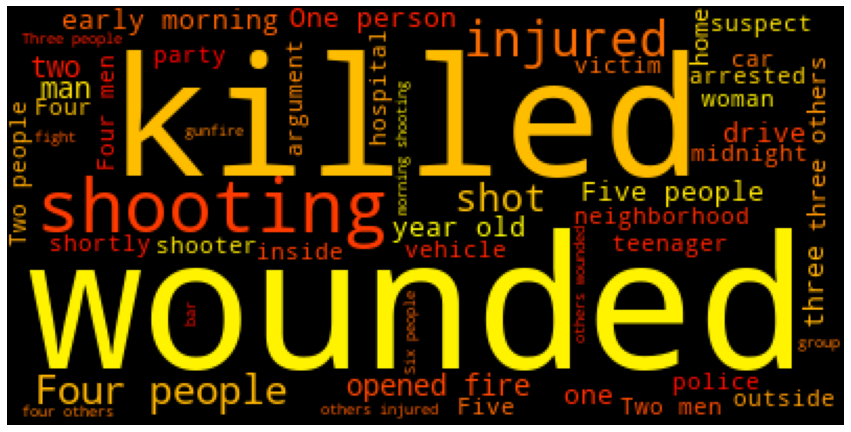

In [7]:
text = ' '.join(df['description'])
cloud = WordCloud(stopwords=STOPWORDS, colormap='autumn', max_words=50).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
plt.show

Самые частые слова:
 - срельба;
 - ранены;
 - убиты.

На места действий указывают такие слова как: 
 - дом;
 - вечеринка;
 - машина.

Время проишествия:
 - полночь;
 - утро.

Еще очень часто упаминаются женщины и подростки.

## <a id="eda">Анализ</a>

### <a id="3.1">Тенденция массовых расстрелов</a>

**По годам**

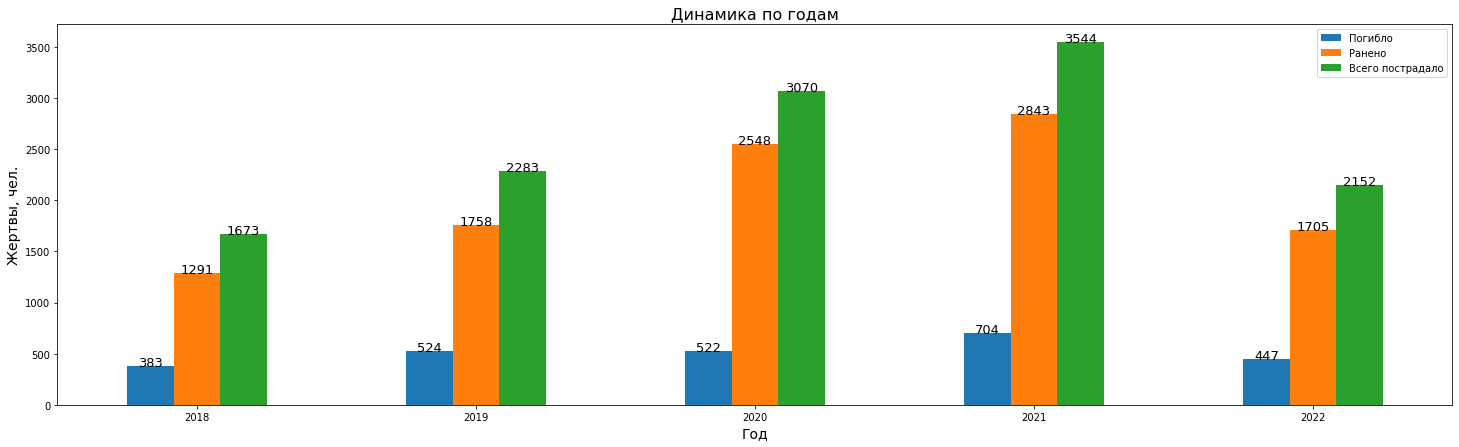

In [8]:
years_trend = df.pivot_table(index='year', values=['dead', 'injured', 'total'], aggfunc='sum').reset_index()
ax=years_trend.plot(x='year', y=['dead', 'injured', 'total'], kind='bar', figsize=(25, 7), rot=360, grid=False)
for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2,
		height,
		'{:.0f}'.format(height),
		fontsize = 13,
		ha='center')
plt.legend(['Погибло', 'Ранено', 'Всего пострадало'])
plt.title('Динамика по годам', size=16)
plt.xlabel('Год', size=14)
plt.ylabel('Жертвы, чел.', size=14)
plt.show()

Динамика увеличивается до 2021 года, в 2022 находится на отметке 2019 года, и это информация только до июля.

**Среднее число жертв в год**

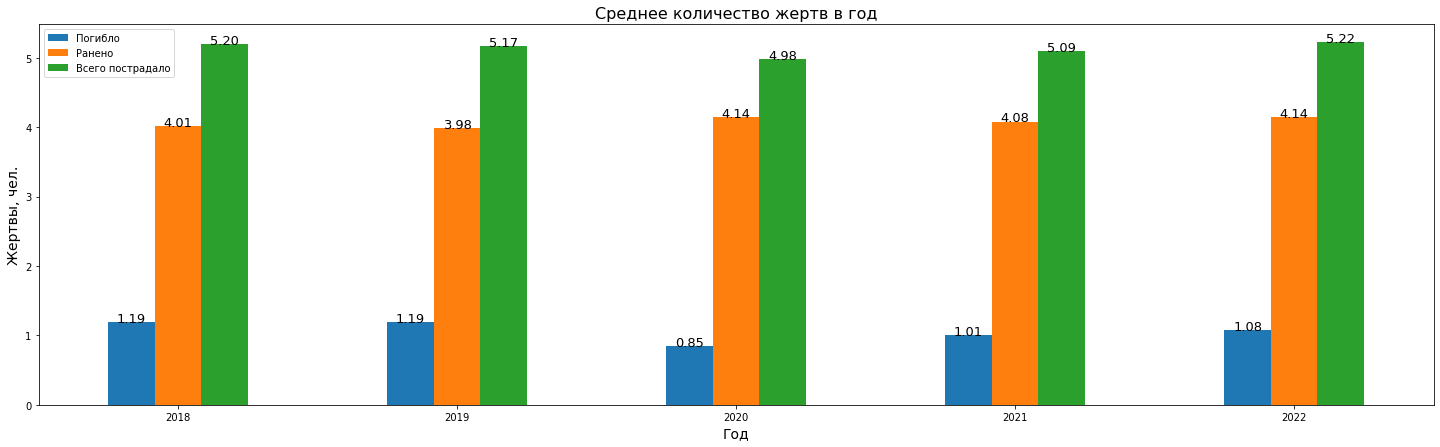

In [9]:
years_trend_mean = df.pivot_table(index='year', values=['dead', 'injured', 'total'], aggfunc='mean').round(2).reset_index()
ax=years_trend_mean.plot(x='year', y=['dead', 'injured', 'total'], kind='bar', figsize=(25, 7), rot=360, grid=False)
for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2,
		height,
		'{:.2f}'.format(height),
		fontsize = 13,
		ha='center')
plt.legend(['Погибло', 'Ранено', 'Всего пострадало'])
plt.title('Среднее количество жертв в год', size=16)
plt.xlabel('Год', size=14)
plt.ylabel('Жертвы, чел.', size=14)
plt.show()

Среднее число пострадавших примерно равно от года к году, но посмотрим что покажет анализ тренда.

**По месяцам**

Сформируем таблицы с данными разделенными по годам и сгруппированные по месяцам.

In [10]:
month_trend = df.pivot_table(index=['year', 'month'], values=['dead', 'injured', 'total'], aggfunc='sum').reset_index()
month_trend.head()

,year,month,dead,injured,total
0,2018,1,23,89,112
1,2018,2,43,64,107
2,2018,3,15,68,83
3,2018,4,28,91,119
4,2018,5,30,123,153


In [11]:
month_trend_2018 = month_trend.query('year == 2018').groupby('month').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()
month_trend_2019 = month_trend.query('year == 2019').groupby('month').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()
month_trend_2020 = month_trend.query('year == 2020').groupby('month').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()
month_trend_2021 = month_trend.query('year == 2021').groupby('month').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()
month_trend_2022 = month_trend.query('year == 2022').groupby('month').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()

In [12]:
def bar_tables(yer, data, x_col, y_col):
	print(yer)
	ax=data.plot(x=x_col, y=y_col, kind='bar', figsize=(25, 7), rot=360, grid=False)
	for p in ax.patches:
		height = p.get_height()
		ax.text(p.get_x() + p.get_width() / 2,
			height,
			'{:.0f}'.format(height),
			fontsize = 13,
			ha='center')
	plt.legend(['Погибло', 'Ранено', 'Всего пострадало'], loc='upper left')
	plt.title('Динамика по месяцам', size=16)
	plt.xlabel('Месяц, №', size=14)
	plt.ylabel('Жертвы, чел.', size=14)
	plt.show()

2018


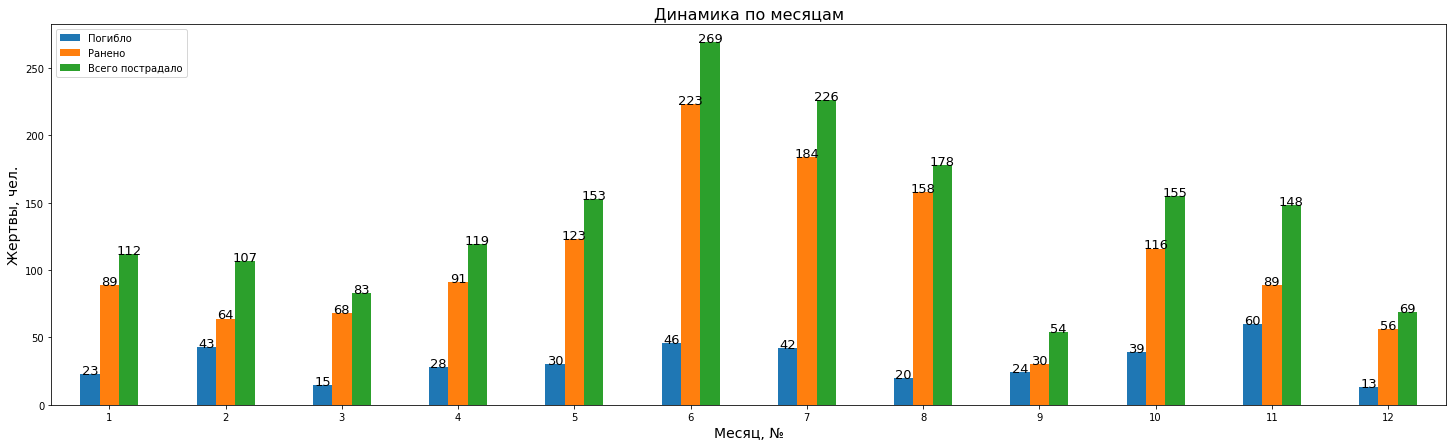

2019


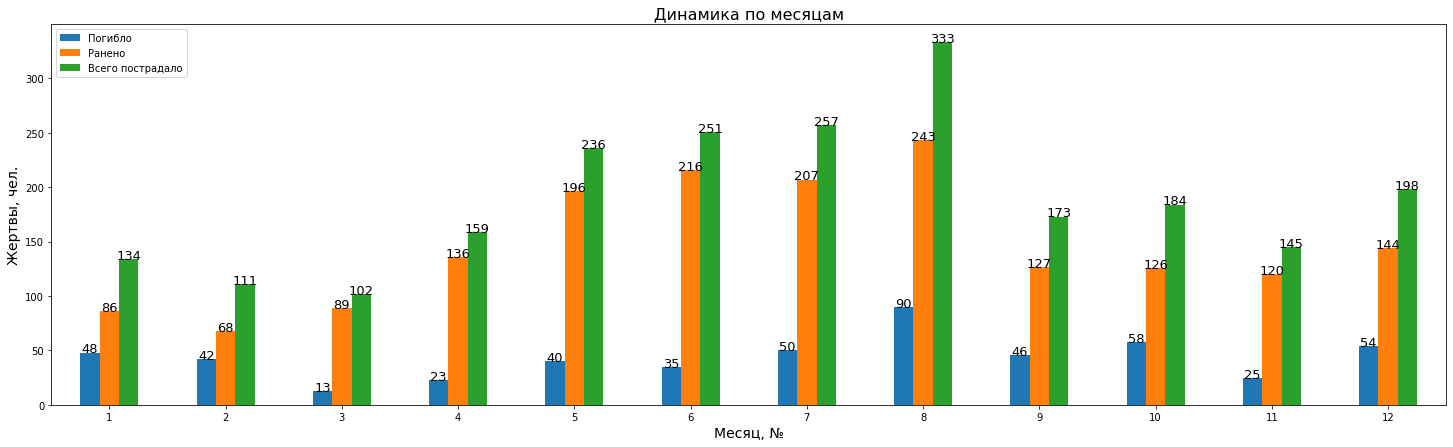

2020


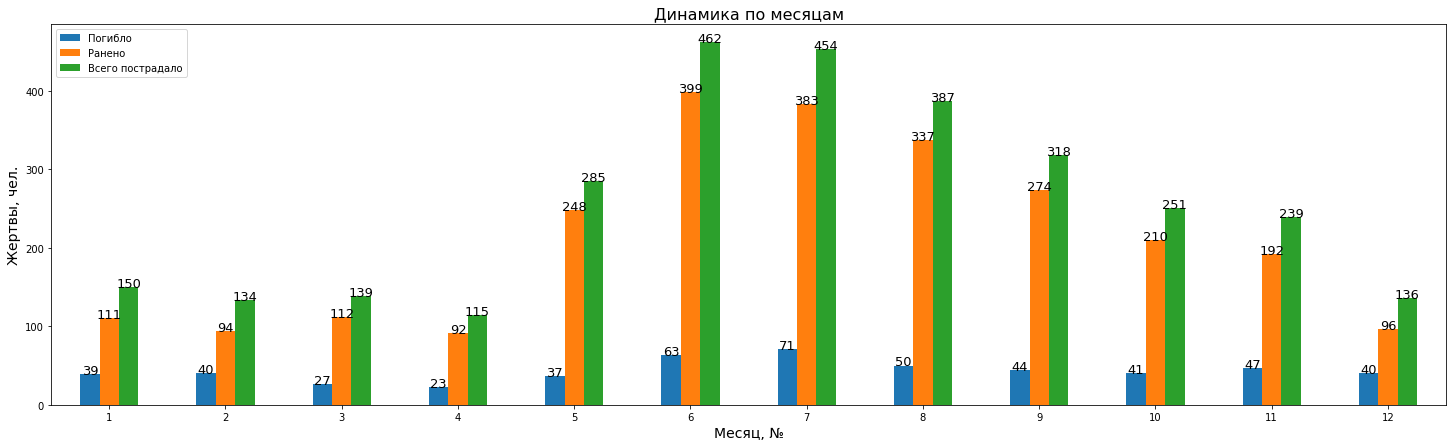

2021


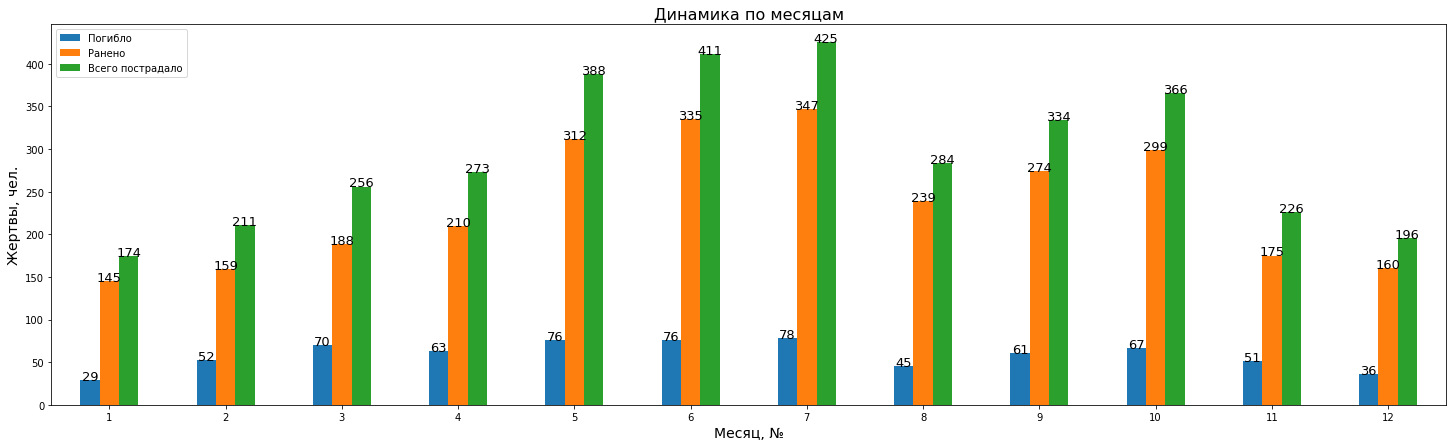

2022


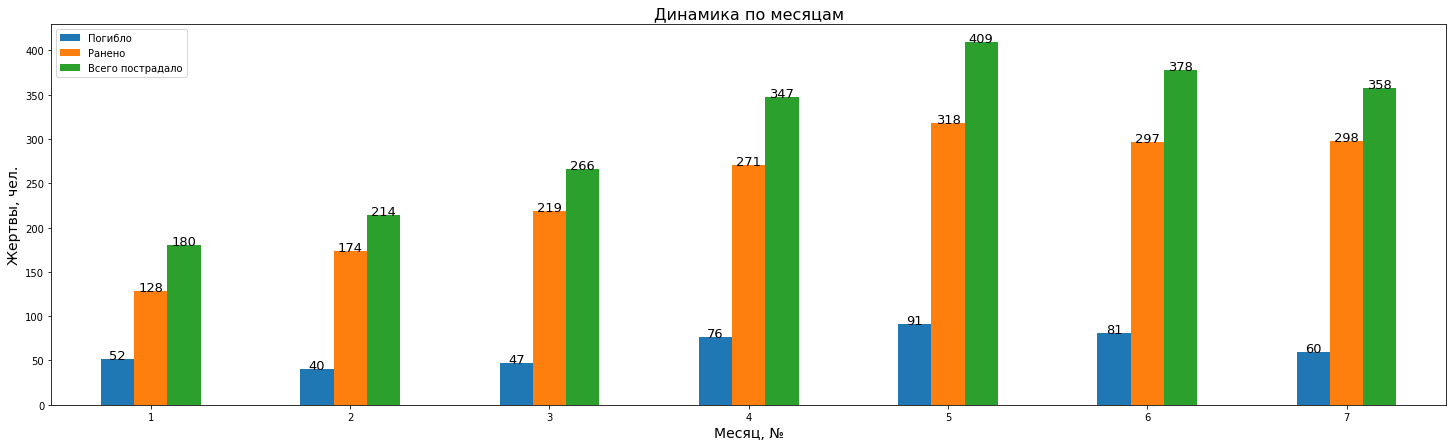

In [13]:
bar_tables(2018, month_trend_2018, 'month', ['dead', 'injured', 'total'])
bar_tables(2019, month_trend_2019, 'month', ['dead', 'injured', 'total'])
bar_tables(2020, month_trend_2020, 'month', ['dead', 'injured', 'total'])
bar_tables(2021, month_trend_2021, 'month', ['dead', 'injured', 'total'])
bar_tables(2022, month_trend_2022, 'month', ['dead', 'injured', 'total'])

Преступные группы активируются летом, и видимо в начале года у них "отпуск".

### <a id="3.2">Прогноз тренда на основе имеющихся данных</a>

Сформируем таблицу с общим числом пострадавших, которое будет разбито на временные отрезки по неделям.

In [14]:
forecast_trend = df.pivot_table(index='date', values='total', aggfunc='sum').reset_index()
forecast_trend.Timestamp = pd.to_datetime(forecast_trend.date, format='%d-%m-%Y')
forecast_trend.index = forecast_trend.Timestamp
forecast_trend = forecast_trend.resample('W').mean()
forecast_trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238 entries, 2018-01-07 to 2022-07-24
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   total   238 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


Разделим данные на тренировочную и тестовую выборки в соотношении 70:30

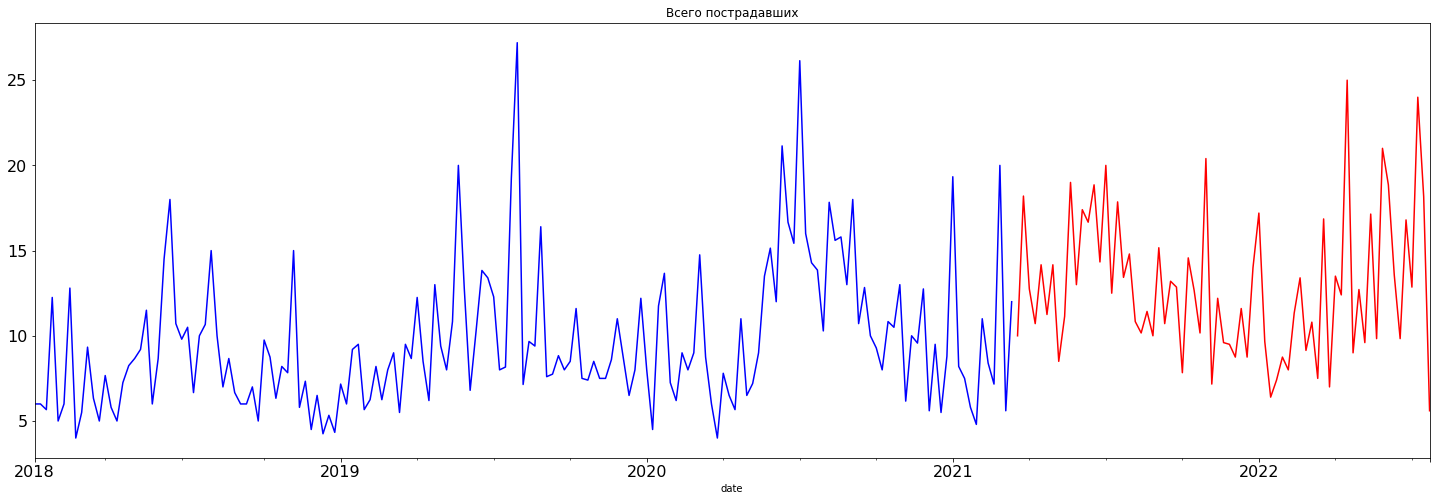

In [15]:
train = forecast_trend[0:167]
test = forecast_trend[167:]

train.total.plot(figsize=(25,8), title= 'Всего пострадавших', fontsize=16, color='blue')
test.total.plot(figsize=(25,8), title= 'Всего пострадавших', fontsize=16, color='red')
plt.show()

Используем метод линейного тренда Хола

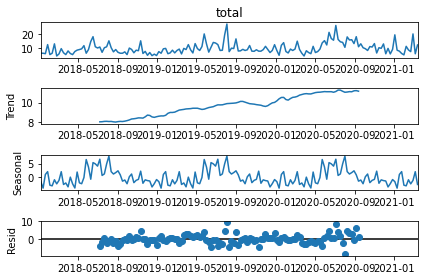

In [16]:
sm.tsa.seasonal_decompose(train.total).plot()
result = sm.tsa.stattools.adfuller(train.total)
plt.show()

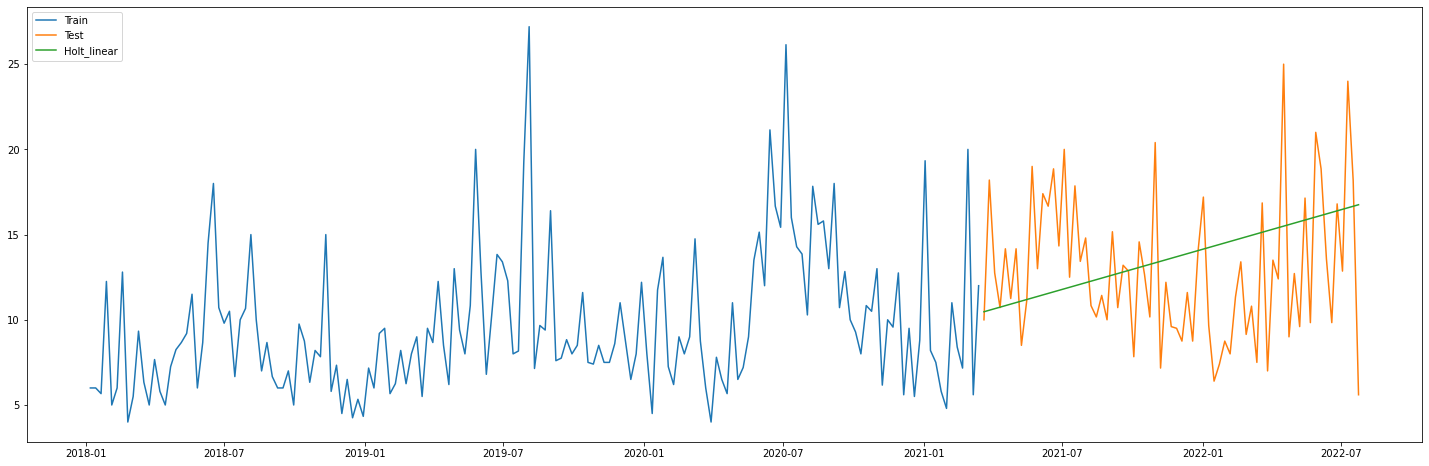

In [17]:
y_hat_avg = test.copy()

fit1 = Holt(np.array(train['total'])).fit(smoothing_level = 0.3, smoothing_slope=0.1)
y_hat_avg['holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(25,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_avg['holt_linear'], label='Holt_linear')
plt.legend(loc='upper left')
plt.show()

In [18]:
rms = sqrt(mean_squared_error(test.total, y_hat_avg.holt_linear))
print('RMSE =', rms)

RMSE = 4.66873438749048


Показатель RMSE позволяет с уверенностью сказать, что имеется растущий тренд.

### <a id="3.3">Города и штаты с наибольшим количеством расстрелов</a>

**Города**

Сгруппируем таблицу по городам и займемся первыми 20 городами.

In [19]:
city_shooting = df.groupby('city').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).sort_values(by='total', ascending=False).head(20)
city_shooting

,dead,injured,total
city,,,
Chicago,111,877,988
Philadelphia,45,369,414
New York City,27,286,313
Houston,68,186,254
Baltimore,28,206,234
New Orleans,31,163,194
Washington D.C.,21,163,184
Detroit,28,128,156
Atlanta,14,133,147


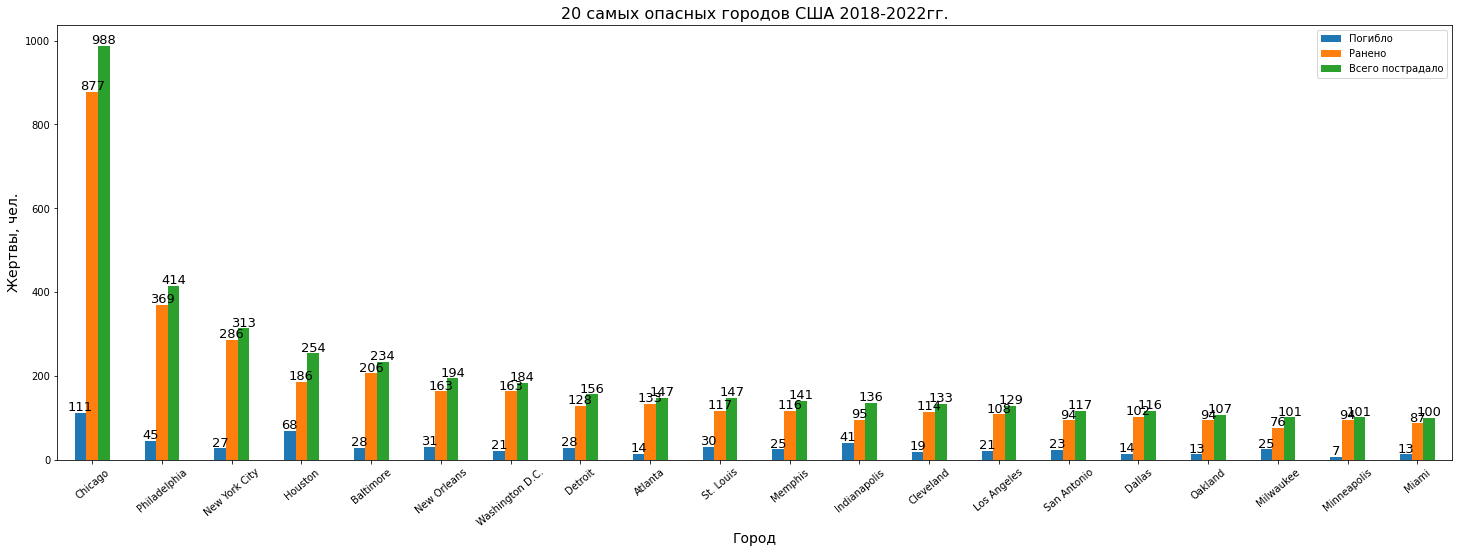

In [20]:
ax = city_shooting.plot(kind='bar', figsize=(25, 8), rot=40, grid=False)
for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2,
		height + 5,
		'{:.0f}'.format(height),
		fontsize = 13,
		ha='center')
plt.legend(['Погибло', 'Ранено', 'Всего пострадало'], loc='upper right')
plt.title('20 самых опасных городов США 2018-2022гг.', size=16)
plt.xlabel('Город', size=14)
plt.ylabel('Жертвы, чел.', size=14)
plt.show()

Вот и первая двадцатка, но с огромным отрывом лидирует Чикаго, подтверждая свою репутацию.

**Штаты**

Создадим словарь с кодами штатов, затем сгруппируем данные по кодам штатов и построим карту США в соответствии с имеющимися данными. Учитывать будем общую сумму без разделения на временные промежутки.

In [21]:
state_code = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

df['state_code'] = df.state.replace(state_code)
df.head()

,date,city,state,dead,injured,total,description,year,month,state_code
0,2022-07-23,Renton,Washington,1,6,7,"Seven people were shot, one fatally, shortly after midnight behind a concert hall.",2022,7,WA
1,2022-07-23,Chicago,Illinois,0,4,4,"A man got out of a black truck and opened fire with a rifle on a group of people in the East Garfield Park neighborhood, leaving four people injured.",2022,7,IL
2,2022-07-22,Maquoketa,Iowa,4,0,4,"Iowa State Park shooting: A man shot and killed three members of a family, including a child, as they were in their tent in Maquoketa Caves State Park before committing suicide in an apparent rand...",2022,7,IA
3,2022-07-21,Los Angeles,California,0,4,4,Two men shot four people standing outside a CVS in the Historic Core.,2022,7,CA
4,2022-07-19,Lincoln,Nebraska,0,4,4,"Four people, including a teenager, were shot in the Hartley neighborhood.",2022,7,NE


In [22]:
state_map = df.groupby('state_code').agg({'dead':'sum', 'injured':'sum', 'total':'sum'}).reset_index()
state_map.head()

,state_code,dead,injured,total
0,AK,6,12,18
1,AL,72,261,333
2,AR,34,137,171
3,AZ,42,115,156
4,CA,251,753,1004


In [23]:
fig = px.choropleth(state_map,
		locations='state_code',
		locationmode='USA-states',
		scope='usa',
		color='dead',
		range_color=[1, 350],
		width=800,
		height=600)
fig.update_layout(title_text = 'Всего погибших в массовых расстрелах в США 2018-2022гг.')
fig.show()

In [24]:
fig = px.choropleth(state_map,
		locations='state_code',
		locationmode='USA-states',
		scope='usa',
		color='injured',
		range_color=[1, 1100],
		width=800,
		height=600)
fig.update_layout(title_text = 'Всего раненых в массовых расстрелах в США 2018-2022гг.')
fig.show()

In [25]:
fig = px.choropleth(state_map,
		locations='state_code',
		locationmode='USA-states',
		scope='usa',
		color='total',
		range_color=[1, 1400],
		width=800,
		height=600)
fig.update_layout(title_text = 'Всего пострадавших в массовых расстрелах в США 2018-2022гг.')
fig.show()

## <a id="end">Выводы</a>

В ходе нашей работы мы сделали следующее:
 - создали облако слов из описаний проишествий;
 - провели анализ динамики и сформировали прогноз тренда;
 - определили среднее количество пострадавших за каждый год;
 - определили самые опасные города и штаты.

Облако слов показадо, что самыми частыми словами в описаниях являются:
 - срельба;
 - ранены;
 - убиты.

На места действий указывают такие слова как:
 - дом;
 - вечеринка;
 - машина.

Время проишествия:
 - полночь;
 - утро.

Во время анализа динамики было уствновлено:
 - от года к году количество жертв увеличивается;
 - самая большая активность преступлений наблюдается летом;
 - мы имеем растущий тренд уровня преступности.

Среднее чило пострадавших по годам примерно равно.

Тройка городов-лидеров по уровню преступности:
 - Чикаго;
 - Филадельфия;
 - Нью-Йорк.

Тройка штатов-лидеров по уровню преступности:
 - Иллинойс;
 - Техас;
 - Калифорния.